# Dependencies

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#%cd drive/MyDrive/ML_finance/personal

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import matplotlib.patches as mpatches

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (train_test_split,
                                     KFold,
                                     cross_val_score,
                                     GridSearchCV,
                                    RandomizedSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import (AdaBoostClassifier,
                              GradientBoostingClassifier,
                              RandomForestClassifier,
                              ExtraTreesClassifier)

from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             accuracy_score,
                            accuracy_score,
                            recall_score)

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from tqdm import tqdm

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.manifold import TSNE
import time
from sklearn.decomposition import PCA, TruncatedSVD
import xgboost as xgb
from xgboost import XGBClassifier

#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def plot_distribution(data, data_select) :
    figsize =( 15, 8)
    sns.set_style("ticks")
    s = sns.FacetGrid(data, hue = 'Class',aspect = 2.5, palette ={0 : 'blue', 1 :'red'})
    s.map(sns.kdeplot, data_select, shade = True, alpha = 0.6)
    s.set(xlim=(data[data_select].min(), data[data_select].max()))
    s.add_legend()
    s.set_axis_labels(data_select, 'proportion')
    s.fig.suptitle(data_select)
    plt.show()

# Process Data

## Download and Split Data

In [7]:
#!unzip ./data/creditcard.csv -d ./data

In [3]:
dataset = read_csv('./data/creditcard.csv')

In [4]:
# shape
dataset.shape

(284807, 31)

In [5]:
dataset.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
set(dataset.dtypes.to_list())

{dtype('int64'), dtype('float64')}

In [7]:
dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [8]:
class_names = {0:'Not Fraud', 1:'Fraud'}
print(dataset.Class.value_counts().rename(index = class_names))

Not Fraud    284315
Fraud           492
Name: Class, dtype: int64


In [9]:
df_train, df_test = train_test_split(dataset,
                                     test_size=.2,
                                     stratify = dataset.Class)

num_folds = 10

scaler = StandardScaler().fit(
    df_train['Amount'].values.reshape(-1,1))

df_train['nAmount'] = scaler.transform(
    df_train['Amount'].values.reshape(-1,1))

df_test['nAmount'] = scaler.transform(
    df_test['Amount'].values.reshape(-1,1))

df_train.drop(columns=['Time','Amount'],inplace=True)
df_test.drop(columns=['Time','Amount'],inplace=True)

Y_train, Y_test = df_train["Class"], df_test["Class"]

X_train = df_train.drop(columns = ["Class"])
X_test = df_test.drop(columns = ["Class"])

## EDA

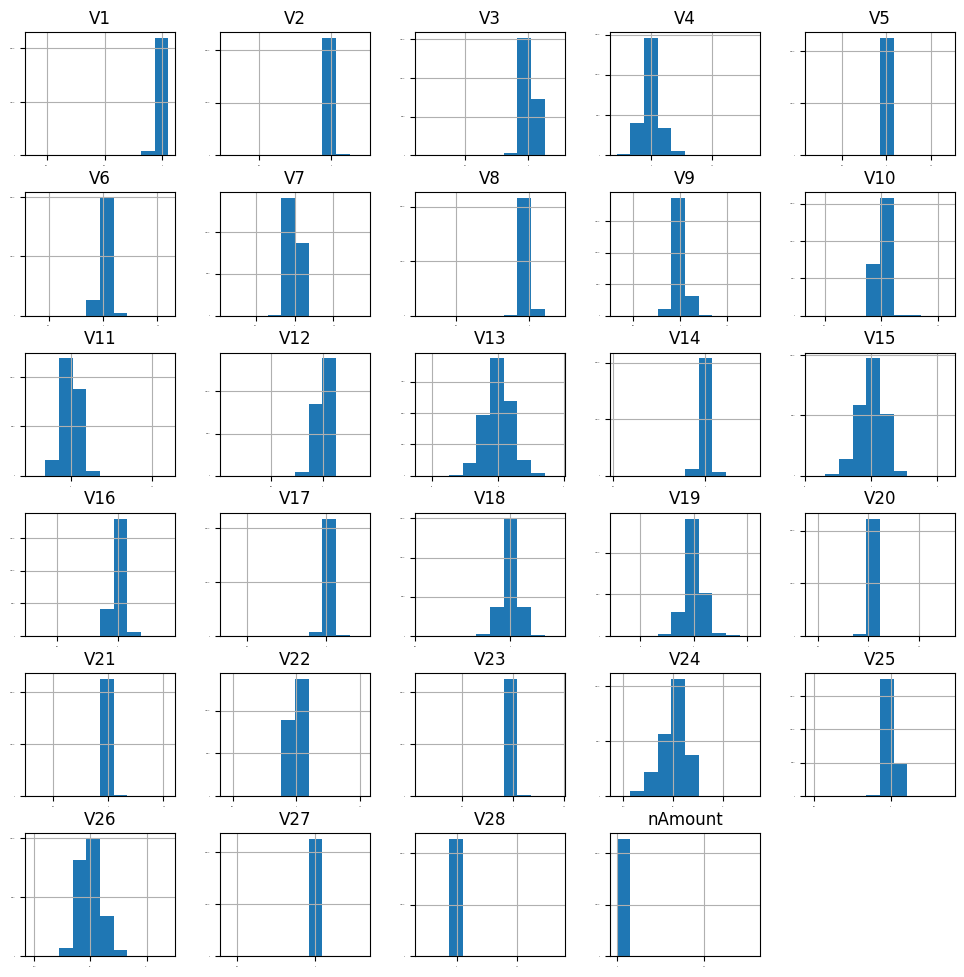

In [10]:
# histograms
X_train.hist(sharex=False,
             sharey=False,
             xlabelsize=1,
             ylabelsize=1,
             figsize=(12,12))
plt.show()

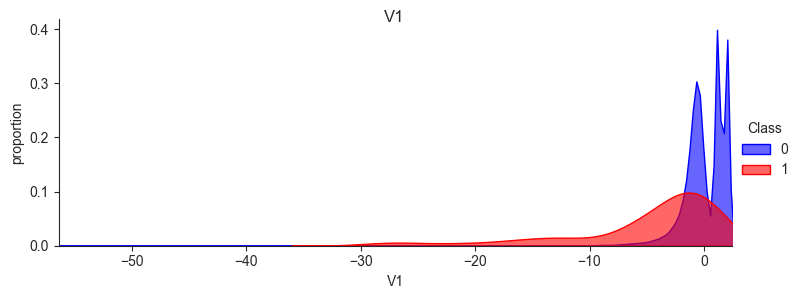

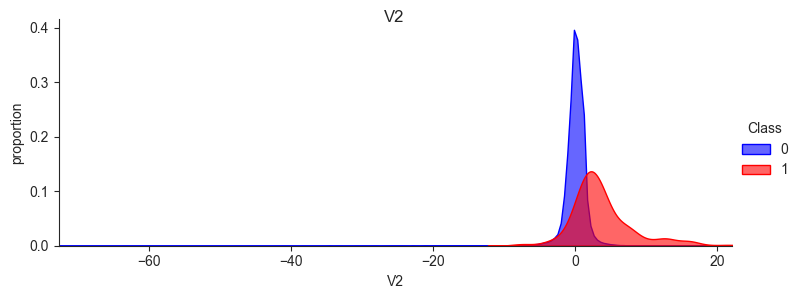

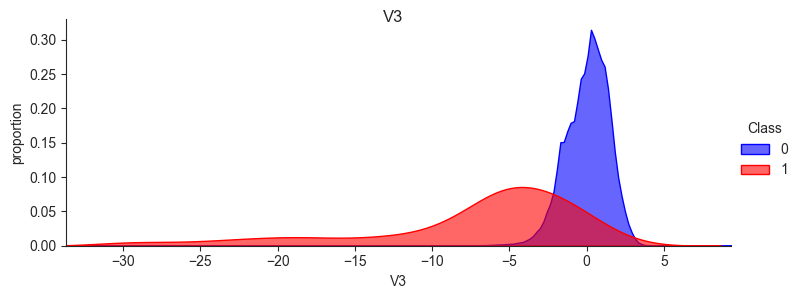

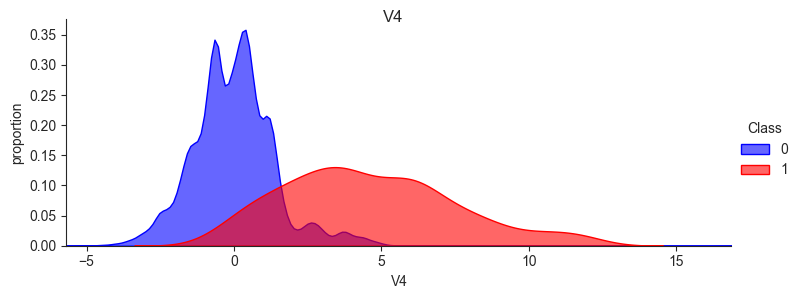

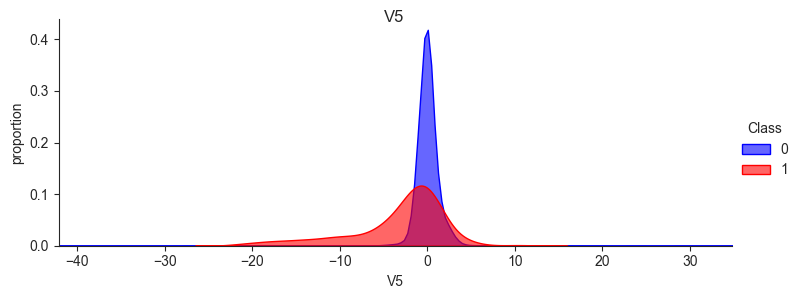

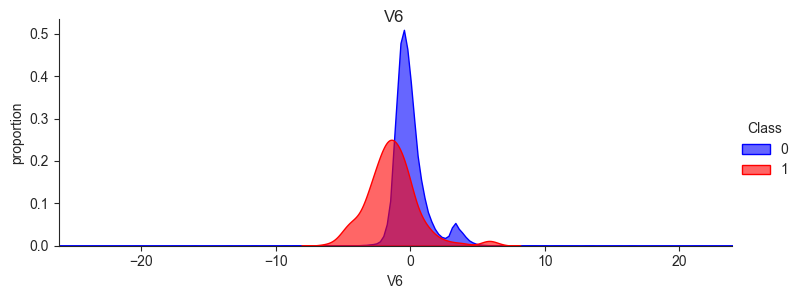

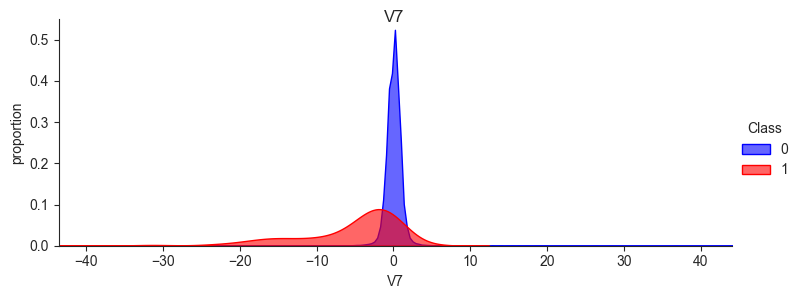

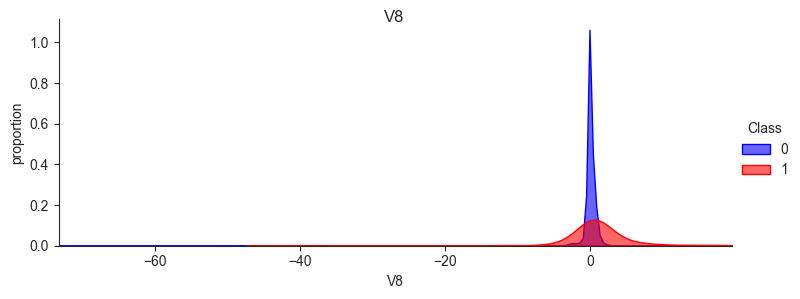

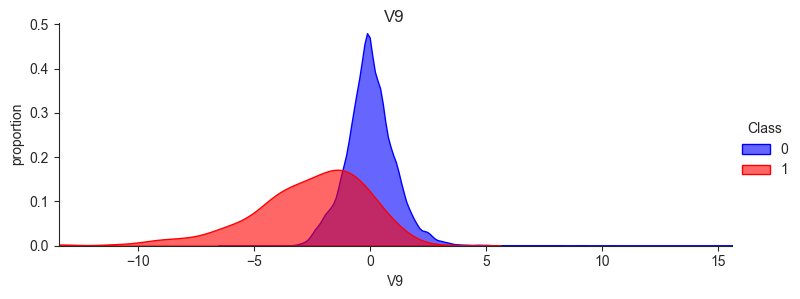

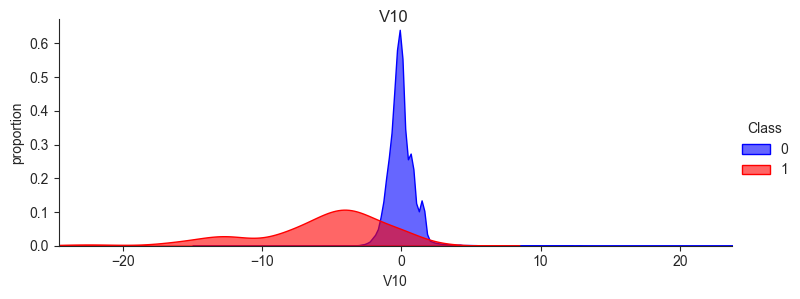

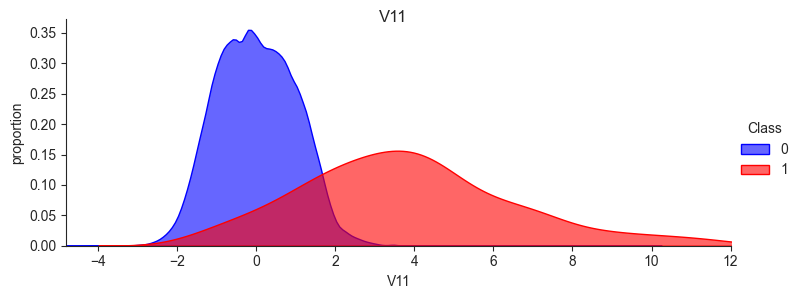

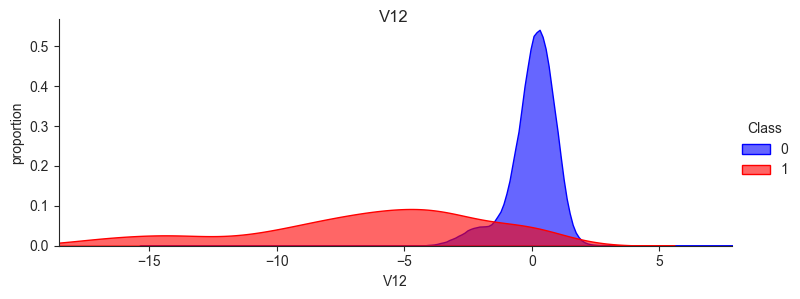

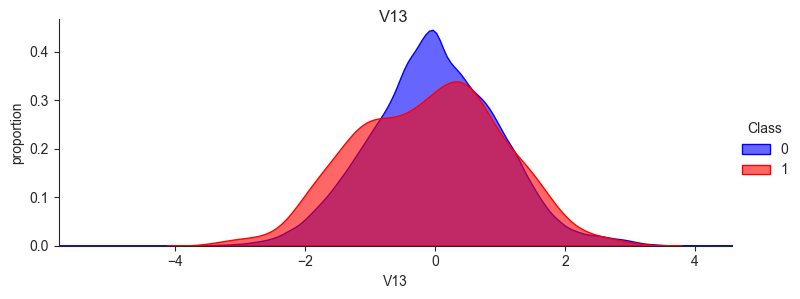

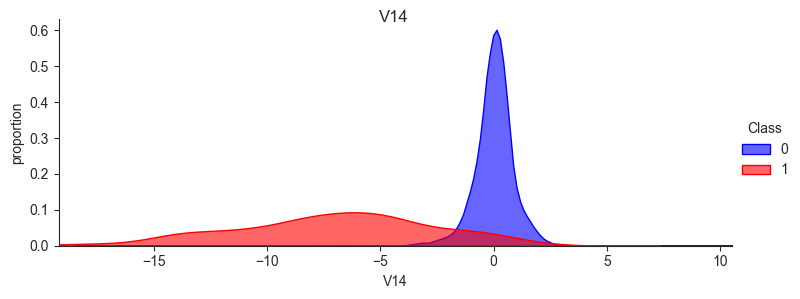

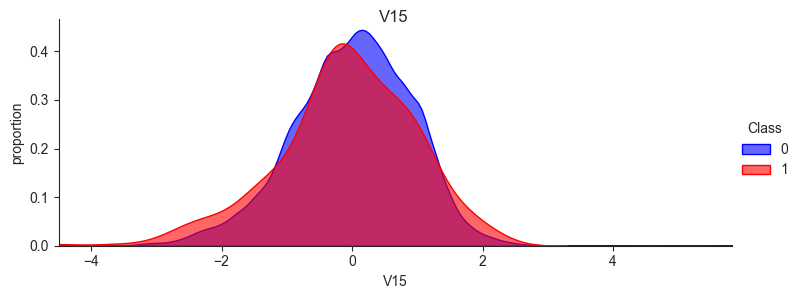

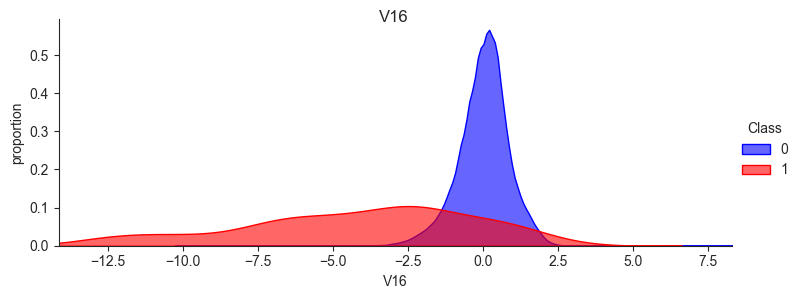

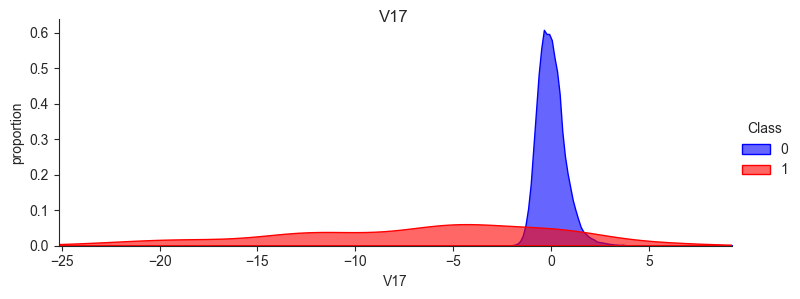

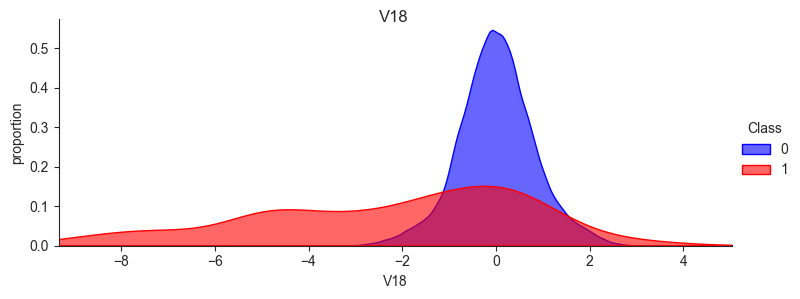

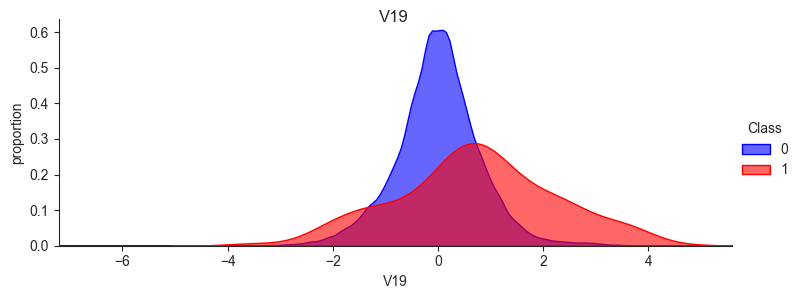

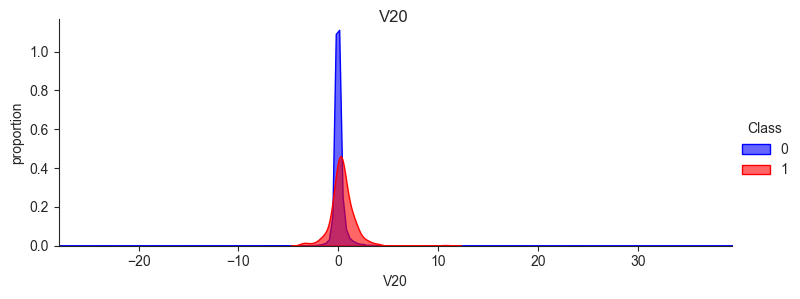

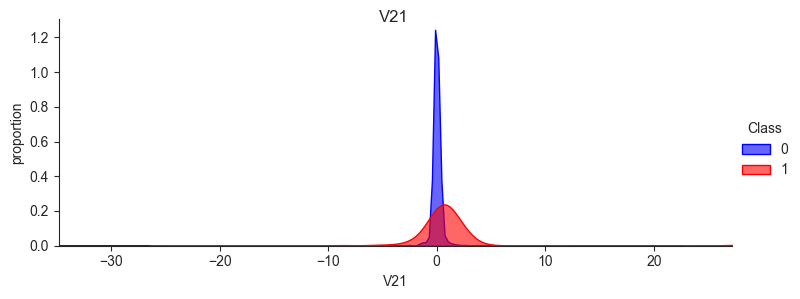

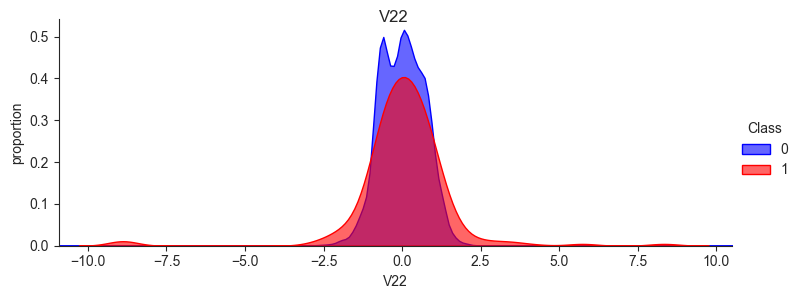

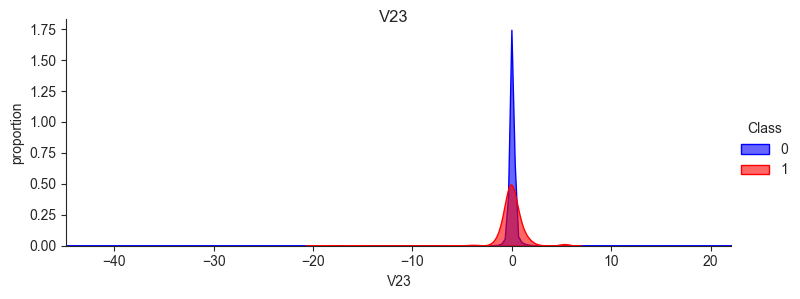

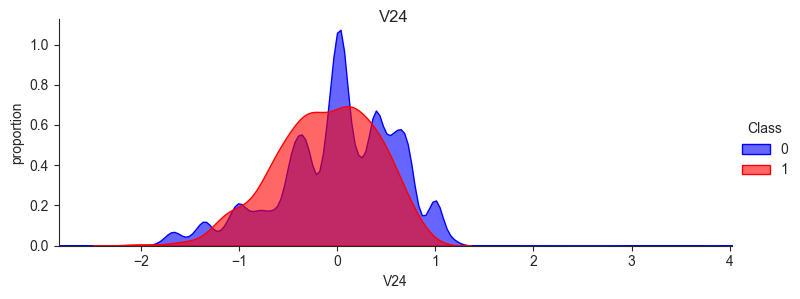

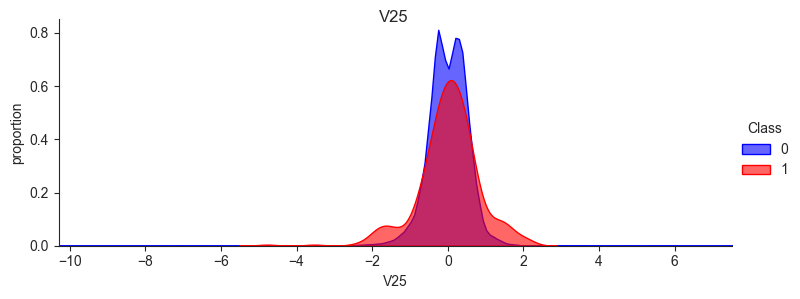

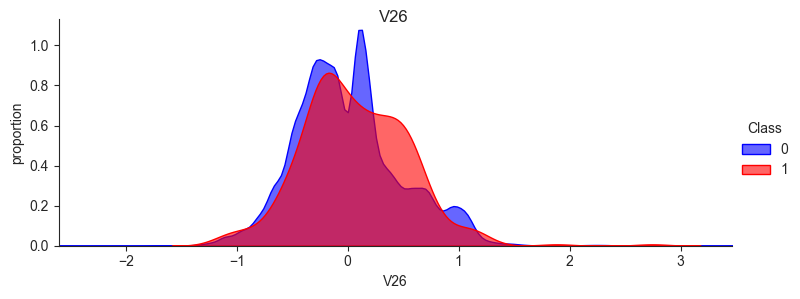

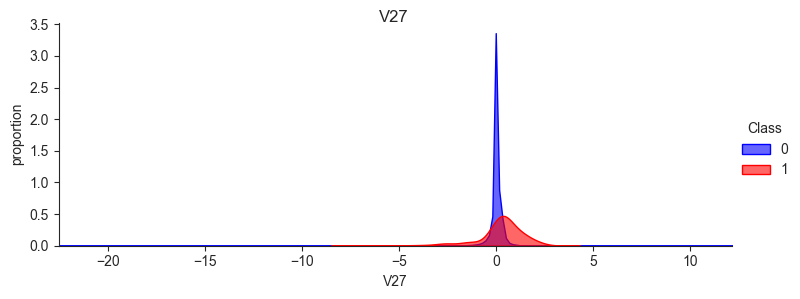

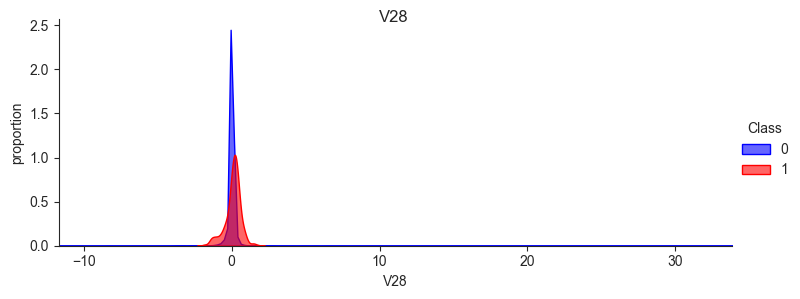

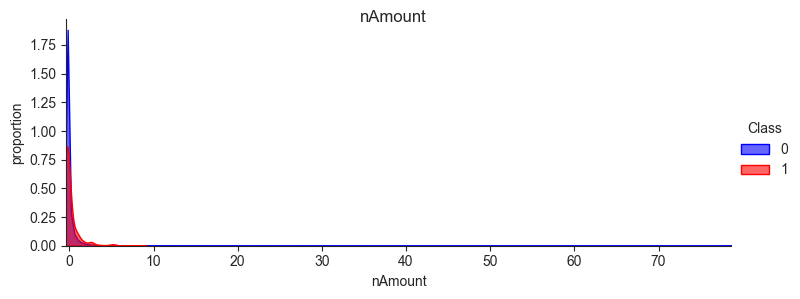

In [11]:
for col in df_train.columns:
    if col == 'Class':
        continue
    plot_distribution(df_train,col)

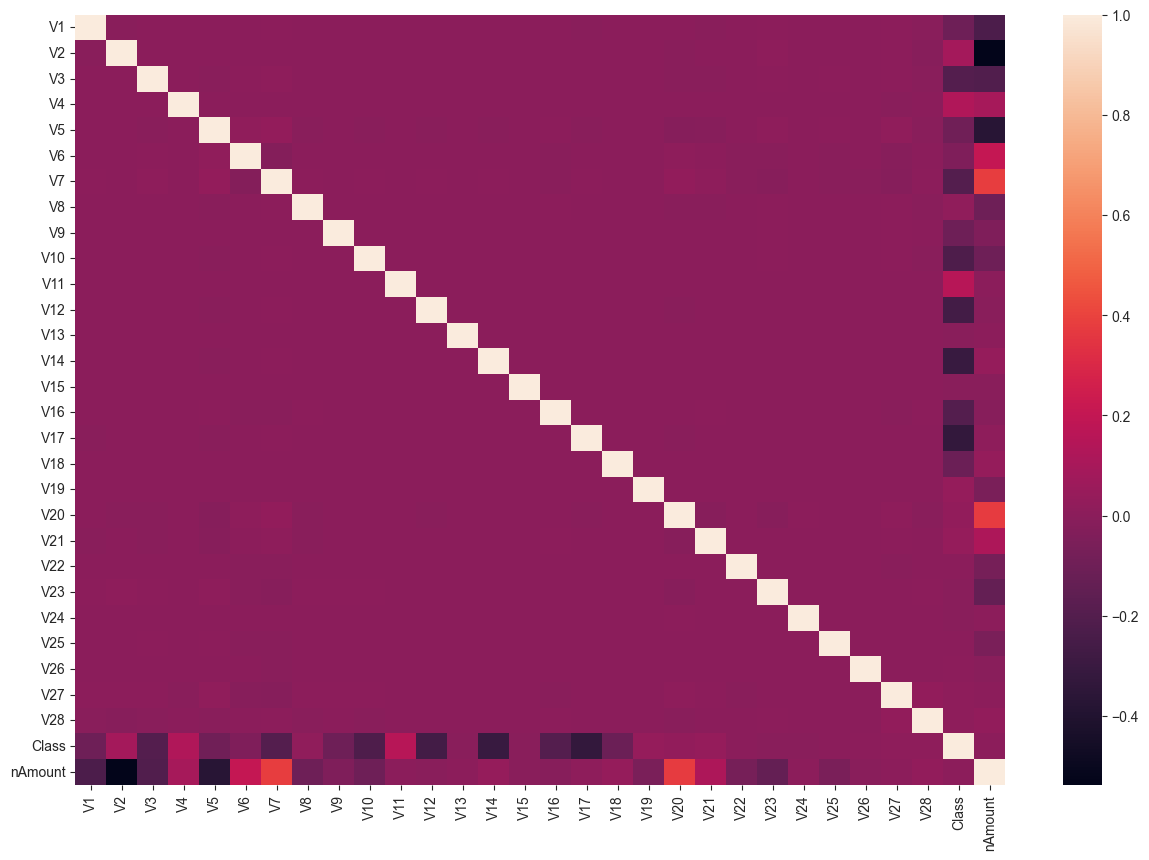

In [12]:
f, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df_train.corr());
plt.show()

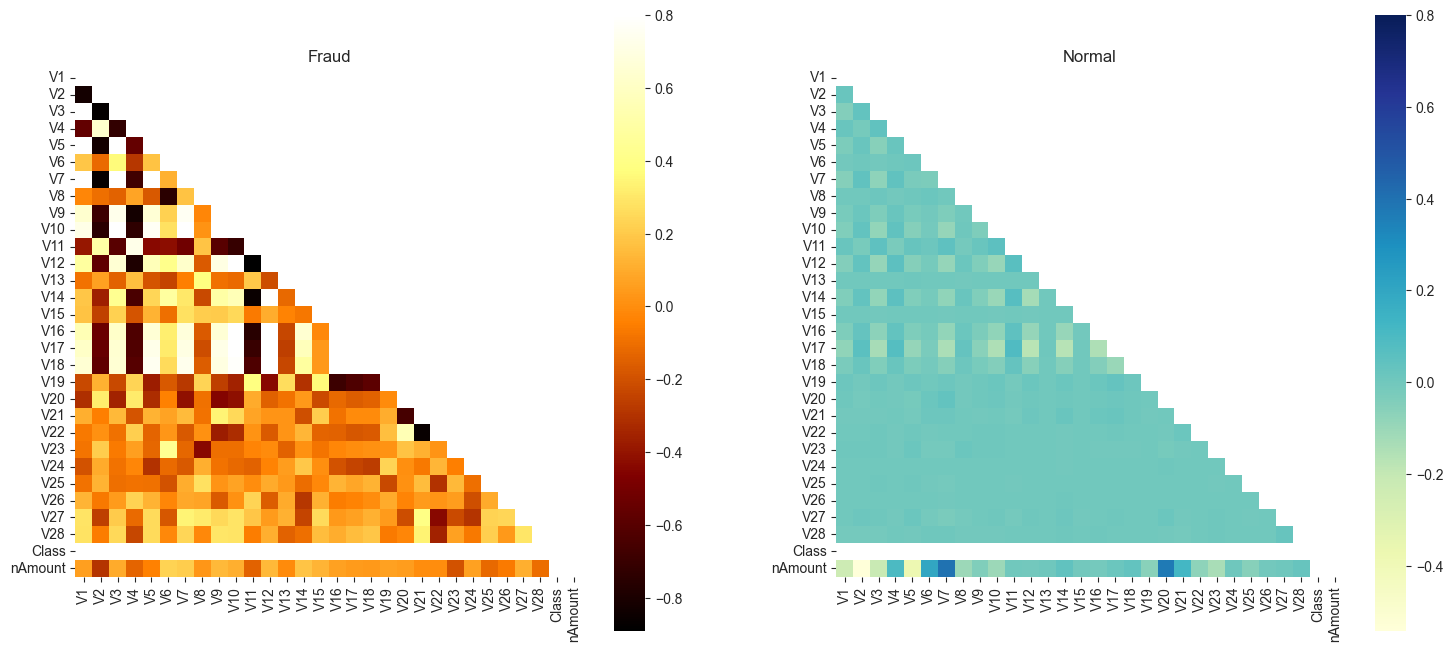

In [15]:
# Correlation matrix
f, (ax1, ax2) = plt.subplots(1,2,figsize =(18, 8))
corr = df_train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap((df_train.loc[df_train['Class']==1]).corr(),
            vmax = .8, square=True,
            ax = ax1,
            cmap = 'afmhot',
            mask=mask);

ax1.set_title('Fraud');
sns.heatmap((df_train.loc[df_train['Class'] ==0]).corr(),
            vmax = .8, square=True,
            ax = ax2,
            cmap = 'YlGnBu',
            mask=mask);
ax2.set_title('Normal');
plt.show()

In [16]:
df_fraud = df_train[df_train['Class']==1]
df_non_fraud_samp = df_train[df_train['Class']==0].sample(n=len(df_fraud))
df_downsampled = pd.concat([df_fraud,df_non_fraud_samp]).sample(frac=1)

In [17]:
Y_downsampled = df_downsampled['Class']
X_downsampled = df_downsampled.drop(columns=['Class'])

In [18]:
# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_downsampled.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X_downsampled.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2,
                             algorithm='randomized',
                             random_state=42).fit_transform(X_downsampled.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 1.4 s
PCA took 0.02 s
Truncated SVD took 0.0043 s


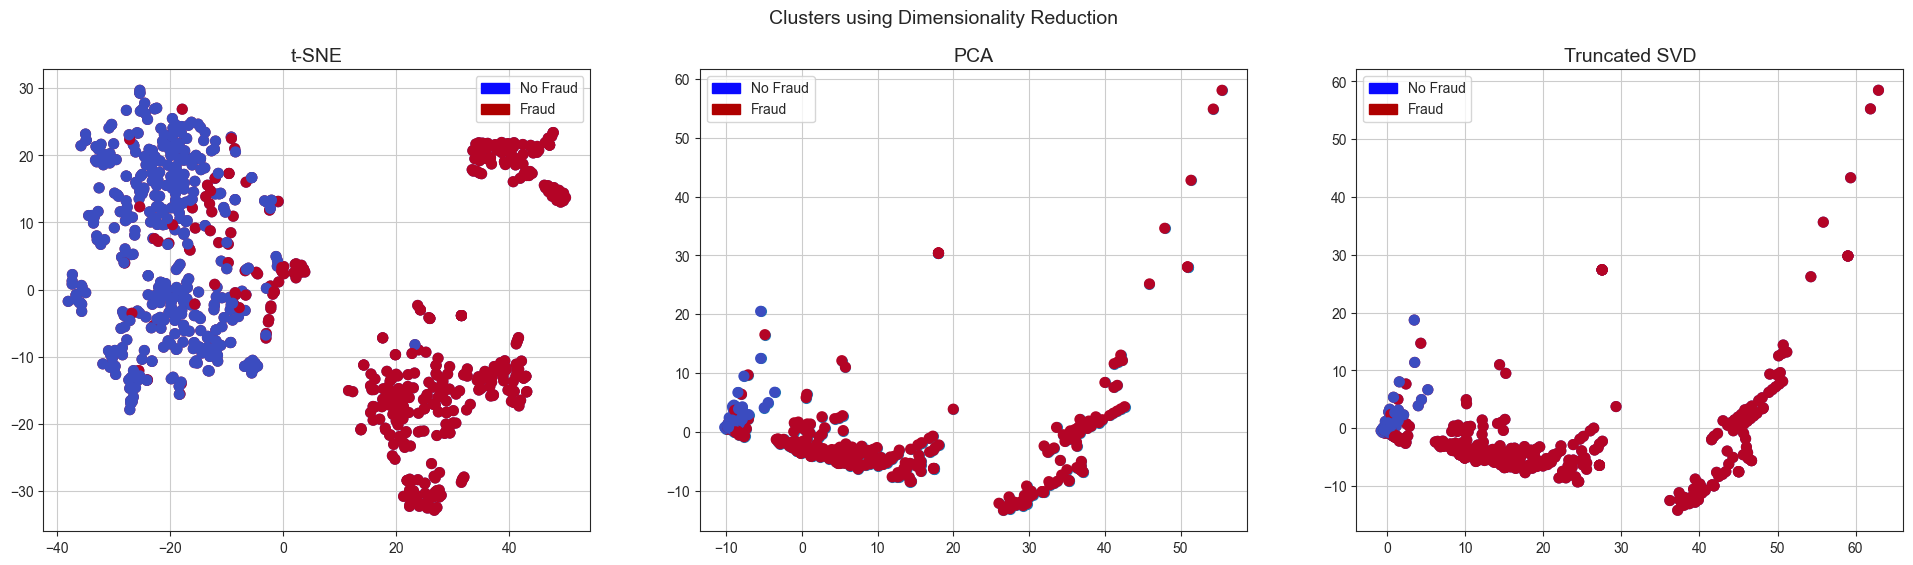

In [19]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(Y_downsampled == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(Y_downsampled == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(Y_downsampled == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(Y_downsampled == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(Y_downsampled == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

# Full Training

## Sklearn

### Stratified Split

In [20]:
models = []

models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
#Neural Network
models.append(('NN', MLPClassifier()))

# # Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))

In [21]:
results_unbal = {}
scoring = 'recall'
seed = 123

for name, model in tqdm(models):
    kfold = StratifiedShuffleSplit(n_splits=num_folds,
                                   random_state=seed)

    cv_results = cross_val_score(model,
                                 X_train,
                                 Y_train,
                                 cv=kfold,
                                 scoring=scoring)
    results_unbal[name] = cv_results

    print(f'\n{name}: {round(cv_results.mean(),3)} ({round(cv_results.std(),3)})')

 10%|████▍                                       | 1/10 [00:07<01:03,  7.03s/it]


LR: 0.662 (0.087)


 20%|████████▊                                   | 2/10 [00:11<00:44,  5.57s/it]


LDA: 0.769 (0.072)


 30%|█████████████▏                              | 3/10 [02:06<06:27, 55.29s/it]


CART: 0.767 (0.073)


 40%|█████████████████▌                          | 4/10 [02:07<03:23, 33.89s/it]


NB: 0.844 (0.066)


 50%|█████████████████████▌                     | 5/10 [18:56<32:08, 385.70s/it]


SVM: 0.7 (0.068)


 60%|█████████████████████████▊                 | 6/10 [27:02<27:58, 419.67s/it]


NN: 0.779 (0.052)


 70%|██████████████████████████████             | 7/10 [48:27<35:07, 702.60s/it]


RF: 0.79 (0.065)


 80%|██████████████████████████████████▍        | 8/10 [49:45<16:47, 503.95s/it]


ET: 0.787 (0.064)


 90%|████████████████████████████████████▉    | 9/10 [1:01:59<09:35, 575.77s/it]


AB: 0.741 (0.047)


100%|████████████████████████████████████████| 10/10 [1:37:04<00:00, 582.41s/it]


GBM: 0.495 (0.251)


In [22]:
pd.DataFrame(results_unbal).to_csv('./results/results_unbal.csv')

In [23]:
pd.DataFrame(results_unbal).mean()

LR      0.661538
LDA     0.769231
CART    0.766667
NB      0.843590
SVM     0.700000
NN      0.779487
RF      0.789744
ET      0.787179
AB      0.741026
GBM     0.494872
dtype: float64

### Stratified Split + Reweighting

In [24]:
wghts = np.zeros(Y_train.shape[0])
wghts[Y_train==1] = 1/788.
wghts[Y_train==0] = 1/454902.

In [25]:
models = []

models.append(('LR', LogisticRegression()))

models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network

# # Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))

In [26]:
results_bal = {}
names = []
scoring = 'recall'
seed = 123

for name, model in tqdm(models):
    kfold = StratifiedShuffleSplit(n_splits=num_folds,
                                   random_state=seed)

    cv_results = cross_val_score(model,
                                 X_train,
                                 Y_train,
                                 cv=kfold,
                                 scoring=scoring,
                                 fit_params={'sample_weight':wghts})
    results_bal[name] = cv_results
    print(f'\n{name}: {round(cv_results.mean(),3)} ({round(cv_results.std(),3)})')

 14%|██████▍                                      | 1/7 [00:02<00:12,  2.07s/it]


LR: 0.846 (0.063)


 29%|████████████▊                                | 2/7 [00:52<02:32, 30.50s/it]


CART: 0.751 (0.06)


 43%|███████████████████▎                         | 3/7 [00:53<01:08, 17.05s/it]


NB: 0.854 (0.053)


 57%|█████████████████████████▏                  | 4/7 [12:24<14:08, 282.98s/it]


RF: 0.785 (0.061)


 71%|███████████████████████████████▍            | 5/7 [13:39<06:56, 208.05s/it]


ET: 0.777 (0.066)


 86%|█████████████████████████████████████▋      | 6/7 [19:55<04:25, 265.11s/it]


AB: 0.887 (0.053)


100%|████████████████████████████████████████████| 7/7 [54:19<00:00, 465.61s/it]


GBM: 0.887 (0.05)


In [29]:
pd.DataFrame(results_bal).to_csv('./results/results_bal.csv')

In [30]:
pd.DataFrame(results_bal).mean()

LR      0.846154
CART    0.751282
NB      0.853846
RF      0.784615
ET      0.776923
AB      0.887179
GBM     0.887179
dtype: float64

## XGBoost

In [41]:
print(1/788.)
print(1/454902.)

0.0012690355329949238
2.198275672562442e-06


In [31]:
sss = StratifiedShuffleSplit(n_splits = 10,
                       test_size=0.2)
splits = sss.split(X_train,Y_train)

In [ ]:
A*

In [47]:
1/(2*(Y_train==1).sum())

0.0012690355329949238

In [48]:
1/(2*(Y_train==0).sum())

2.198275672562442e-06

In [33]:
for idxs in splits:
    X_train_cv = X_train.iloc[idxs[0]]
    Y_train_cv = Y_train.iloc[idxs[0]]
    
    X_test_cv = X_train.iloc[idxs[1]]
    Y_test_cv = Y_train.iloc[idxs[1]]
    
    
    
    break

In [30]:
xgb_clf = XGBClassifier(X_train_cv, Y_train_cv, sample_weight = 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

# Feature Selection

In [ ]:
bestfeatures = SelectKBest(k=10)
fit = bestfeatures.fit(X_train,Y_train)

df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X_train.columns)

feature_Scores = pd.concat([df_columns,df_scores],axis=1)
feature_Scores.columns = ['Specs','Score']  #naming the dataframe columns
print(feature_Scores.nlargest(10,'Score'))  #print 10 best features

NameError: name 'X_train' is not defined